In [3]:
import pandas as pd

data_mpg = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original",
    delim_whitespace=True,
    header=None,
    names=[
        "mpg",
        "cylinders",
        "displacement",
        "horsepower",
        "weight",
        "acceleration",
        "model year",
        "origin",
        "car name",
    ],
)

data_mpg.dropna(inplace=True)
data_mpg.drop(["model year", "origin", "car name"], axis=1, inplace=True)

/var/folders/5d/bg50v_hd3b90vwxc83124gt00000gn/T/ipykernel_9898/963688916.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data_mpg = pd.read_csv(


In [4]:
### 1 - I have a full graph
### 2 - I define a training schedule
# learner: f()
### 3 - Training schedule + learner = SCM

In [5]:
# training schedule:
# Z -(learner)-> X => F_X(Z)
# Z -(learner)-> Y
# (X - F_X(Z)) -(learner)-> Y - F_Y(Z) (effect of X on Y, conditional on Z)

In [6]:
from magpy.search.astar import AStarSearch
from magpy.search.astar import bic_score_node
import networkx as nx
import numpy
from sklearn.preprocessing import PolynomialFeatures


from typing import Optional

# Y -> parents -> [{ X1, X2 }, { X1, X2, X3}, {}]
# f : parent_set -> score


def my_custom_scoring_function(
    y: numpy.ndarray,
    X: Optional[numpy.ndarray] = None,
    node: Optional[str] = None,
    parent_set: Optional[set] = None,
):
    n = len(y)

    if X is None:
        residual = numpy.sum(y**2)
        dof = 0

    else:
        n, dof = X.shape
        _, residual, _, _ = numpy.linalg.lstsq(a=X, b=y, rcond=None)

    bic = n * numpy.log(residual / n) + dof * numpy.log(n)
    return bic.item()


def my_cross_validation_score(y, X, node, parent_set):
    from sklearn.model_selection import cross_val_score
    from sklearn.ensemble import RandomForestRegressor

    if X is None:
        X = numpy.ones((len(y), 1))
    else:
        X = numpy.column_stack([X, numpy.ones(len(y))])

    model = RandomForestRegressor(n_estimators=100, max_depth=3)
    scores = cross_val_score(
        model, X, y.ravel(), cv=5, scoring="neg_mean_squared_error"
    )
    return -scores.mean()

/Users/andre/magpy/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
astar = AStarSearch(data_mpg)
astar.run_scoring(func=my_custom_scoring_function, parallel=True)

100%|██████████| 192/192 [00:00<00:00, 1605.24it/s]


100%|██████████| 192/192 [00:05<00:00, 36.94it/s]


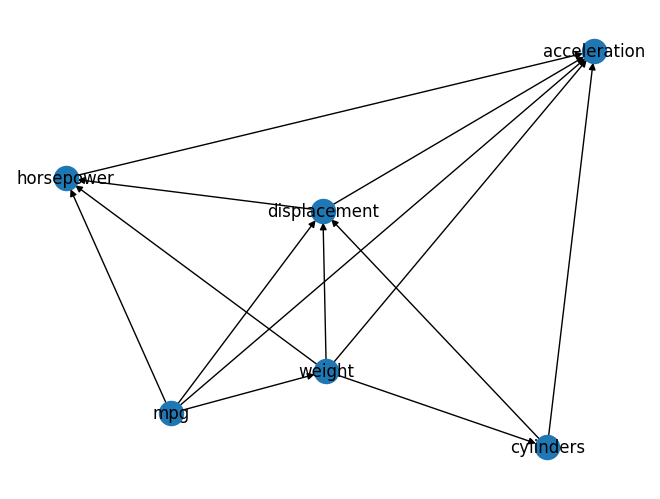

In [7]:
from magpy.search.astar import AStarSearch

data = data_mpg.copy()
data = (data - data.mean()) / data.std()

astar = AStarSearch(data_mpg)
astar.run_scoring(func=my_custom_scoring_function, parallel=True)


mat = astar.search()
G = nx.from_pandas_adjacency(mat, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)

100%|██████████| 160/160 [00:01<00:00, 101.50it/s]


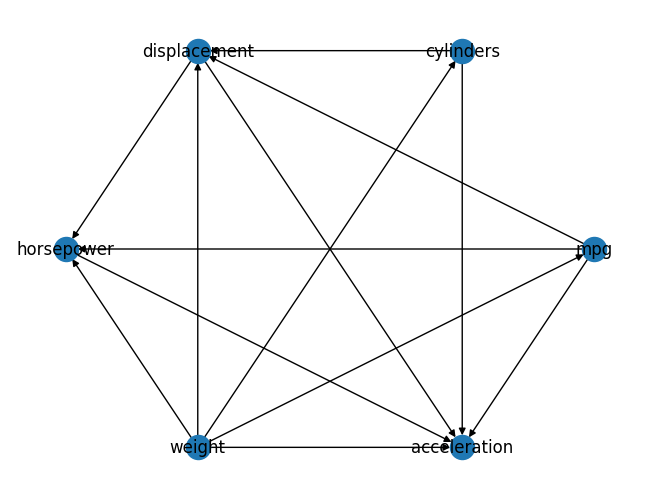

In [12]:
# let's also include the fact that weight is leading to MPG

include_graph = pd.DataFrame(0, index=data_mpg.columns, columns=data_mpg.columns)
include_graph.loc["weight", "mpg"] = 1
include_graph.loc["weight", "cylinders"] = 1

astar = AStarSearch(data_mpg, include_graph=include_graph)
astar.run_scoring(func=bic_score_node, parallel=True)
mat = astar.search()
G = nx.from_pandas_adjacency(mat, create_using=nx.DiGraph)
nx.draw_circular(G, with_labels=True)

In [13]:
from magpy.oracles.oracles import BaseOracle, linear

In [23]:
oracle = BaseOracle(data_mpg, learner=linear)

from magpy.search.pcskeleton import pc_skeleton

skeleton, sepsets = pc_skeleton(oracle, data_mpg.columns)

15it [00:00, 135.54it/s]
15it [00:00, 90.36it/s]
15it [00:00, 157.71it/s]
15it [00:00, 412.53it/s]


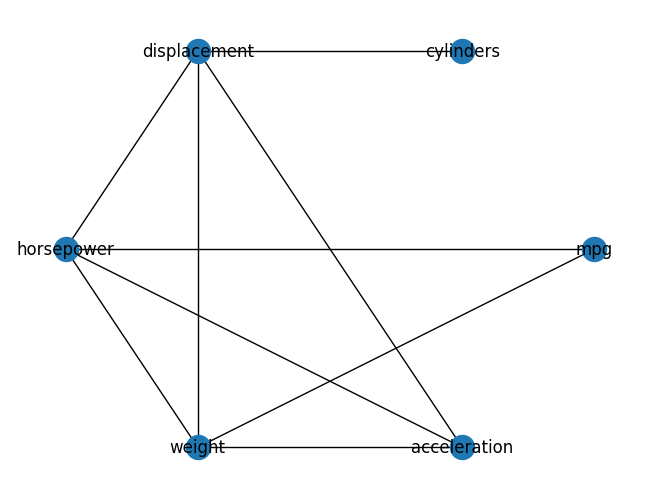

In [24]:
G = nx.from_pandas_adjacency(skeleton)
nx.draw_circular(G, with_labels=True)




100%|██████████| 54/54 [00:03<00:00, 14.70it/s]


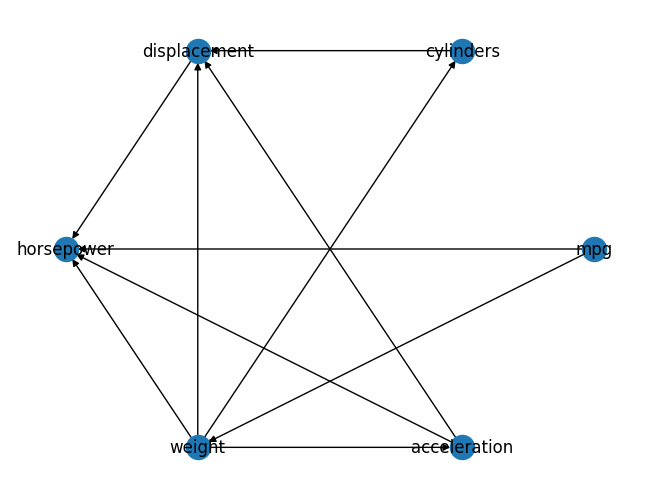

In [30]:
include_graph = pd.DataFrame(0, index=data_mpg.columns, columns=data_mpg.columns)
include_graph.loc["cylinders", "displacement"] = 1
include_graph.loc["weight", "cylinders"] = 1

astar = AStarSearch(data_mpg, super_graph=skeleton, include_graph=include_graph)
astar.run_scoring(func=my_custom_scoring_function, parallel=True)
mat = astar.search()
G = nx.from_pandas_adjacency(mat, create_using=nx.DiGraph)
nx.draw_circular(G, with_labels=True)

In [32]:
from mmmm import SCM


scm = SCM(df, G)
scm.fit().predict.whatif("weight is doubled?")

,mpg,cylinders,displacement,horsepower,weight,acceleration
mpg,0,0,0,1,1,0
cylinders,0,0,1,0,0,0
displacement,0,0,0,1,0,0
horsepower,0,0,0,0,0,0
weight,0,1,1,1,0,1
acceleration,0,0,1,1,0,0


In [22]:
oracle._run("cylinders", "mpg", ["weight", "displacement"])

np.float64(0.5171662551598478)

In [3]:
from causallearn.utils.Dataset import load_dataset

data_sachs, labels = load_dataset("sachs")
df = pd.DataFrame(data_sachs, columns=labels)

In [5]:
astar = AStarSearch(df)
astar.run_scoring(func=bic_score_node, parallel=True)
mat = astar.search()
G = nx.from_pandas_adjacency(mat, create_using=nx.DiGraph)
nx.draw_circular(G, with_labels=True)

  0%|          | 4/11264 [00:00<12:26, 15.08it/s]

KeyboardInterrupt: 

In [58]:
from magpy.oracles.oracles import linear, BaseOracle


z = numpy.random.normal(0, 1, size=1000)
x = (z + numpy.random.normal(0, 1, size=1000)) > 0
y = z + numpy.random.normal(0, 1, size=1000)
df = pd.DataFrame({"x": x, "y": y, "z": z})

df["x"] = (df["x"] > 0).astype(str)


oracle = BaseOracle(df, learner=linear, rank=False)
print(oracle.f_test("x", "y", []))
print(oracle.f_test("x", "y", ["z"]))

UFuncTypeError: Cannot cast ufunc 'lstsq' input 0 from dtype('O') to dtype('float64') with casting rule 'same_kind'

In [72]:
from magpy.oracles.mixed import MixedDataOracle

oracle = MixedDataOracle(df, threshold=0.05)
print(oracle._run("x", "y", []))
print(oracle._run("x", "y", ["z"]))
print(oracle._run("z", "x", []))

5.575268701683751e-42
0.851295008248381
6.5811119973790815e-83


In [73]:
from magpy.search.pcskeleton import pc_skeleton

skeleton, sepsets = pc_skeleton(oracle, df.columns)

In [74]:
sepsets

{('x', 'y'): ('z',)}

In [77]:
from causallearn.utils.Dataset import load_dataset

data_sachs, labels = load_dataset("sachs")
df = pd.DataFrame(data_sachs, columns=labels)

oracle = BaseOracle(df, learner=linear, rank=True)

In [78]:
skeleton, sepsets = pc_skeleton(oracle, df.columns)

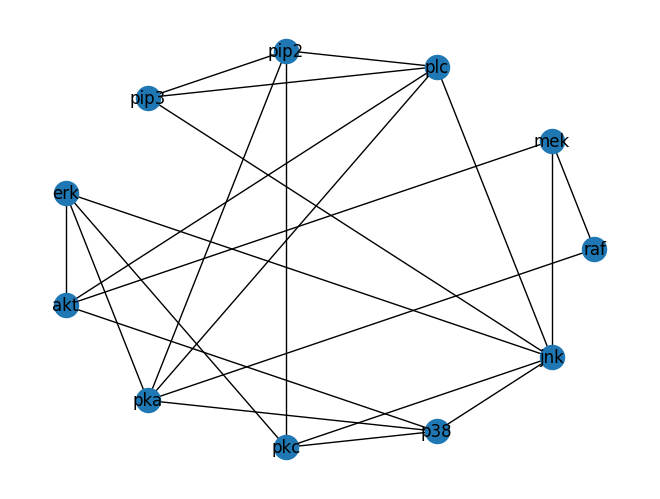

In [80]:
G = nx.from_pandas_adjacency(skeleton)
nx.draw_circular(G, with_labels=True)

100%|██████████| 228/228 [01:58<00:00,  1.92it/s]


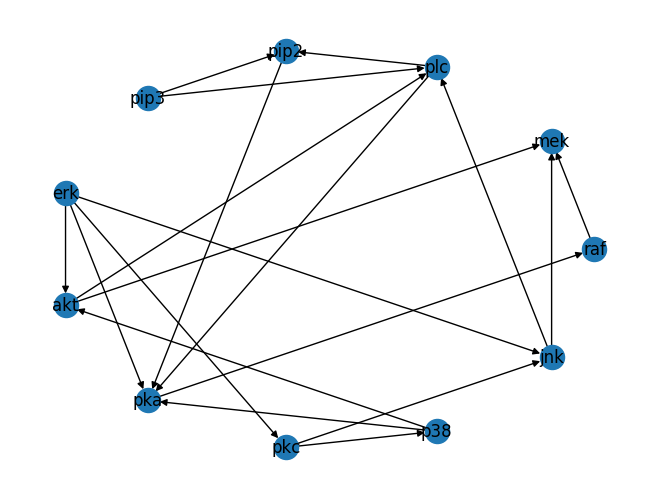

In [83]:
astar = AStarSearch(df, super_graph=skeleton)
astar.run_scoring(func=my_cross_validation_score, parallel=True)
mat = astar.search()
G = nx.from_pandas_adjacency(mat, create_using=nx.DiGraph)
nx.draw_circular(G, with_labels=True)